We start by importing the proper modules (equivalent to libraries in R).

These are

- NumPy
- MatPlotLib
- PIL, (Pillow) an image handler
- tqdm, (pronounced ta-qa-dum) from Arabic (taqadum, تقدّم) meaning *progress*, is a simple progress bar to be able to estimate the time for each task



In [1]:
#pip install -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd

We then initialise the picture that we want to use, and convert it into pixel values, so we can have a pure black and white image of the earth to use.

In [3]:
img = Image.open('earth.jpg')
arr = np.array(img.getdata())

The following forloop checks each individual pixel and the converts it to black or white. The threshold was found through running the loop many times and picking a number that looked good enough.

In [103]:
newPixels = []
threshold = 5

for pixel in tqdm(arr):
    # if it looks like black, convert it to black
    if pixel[0] <= threshold:
        newPixel = (0, 0, 0)
    # if it looks like white, convert it to white
    else:
        newPixel = (255, 255, 255)
    newPixels.append(newPixel)

pd.DataFrame(newPixels).to_csv('newPixels.csv', index = None, header = ['R', 'G', 'B'])

100%|██████████| 2407680/2407680 [00:01<00:00, 2048409.46it/s]


We then generate the new picture and save it before we convert it into an array.

In [104]:
newImg = Image.new(img.mode, img.size)
newImg.putdata(newPixels)
newImg.save('pure-bw-earth.jpg')

img_array=plt.imread('pure-bw-earth.jpg')

In [106]:
# def diffusion(dt,dx,dy,t_max,y_max,viscosity,V0):
    

In [107]:
height = img_array.shape[0]
width = img_array.shape[1]

temp_matrix = np.zeros(shape = (height, width))
# temp_matrix[:,:] = 

for i in tqdm(np.arange(len(img_array))):
    for j in np.arange(len(img_array[0])):
        if img_array[i][j][0] == 255:
            temp_matrix[i][j] = 1000
            
temp_matrix[675:710, 1075:1110] = 2000

diffusion_matrix = np.ones(shape = (height, width))

dx = dy = dt = 1

Tcool, Thot = 300, 700
nx, ny = int(width/dx), int(height/dy)

100%|██████████| 1254/1254 [00:03<00:00, 322.12it/s]


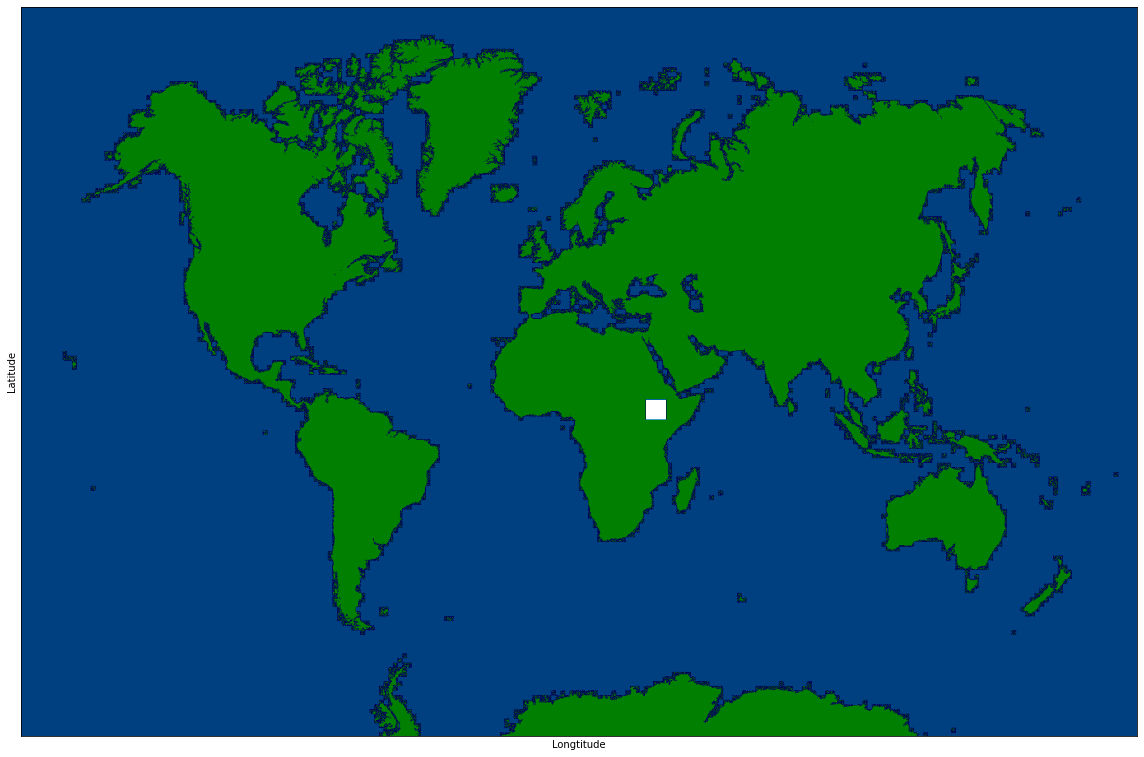

In [108]:
plt.figure(figsize=(20,20))
# plt.imshow(img_array)
plt.imshow(temp_matrix, cmap = 'ocean')
plt.ylabel('Latitude')
plt.xlabel('Longtitude')
plt.xticks([])
plt.yticks([])
plt.savefig('heatmap-earth.jpg')
plt.show()

\begin{equation} \frac{d}{dt}f(x_{i},t) = D\frac{d^{2}}{dx^{2}} f(x_{i},t)\tag{1}\end{equation}